# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we will train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content



Once this project is complete, we will have a fully fucitonal AI application which can be trained on any set of labeled images. Here the neural network will be learning about flowers and end up as a command line application. But, what we do with this new skillset depends on imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Feel free to construct a new dataset and utilize this PyTorch Neural Network on it!

First up is importing the packages we will need. It's good practice to keep all the imports at the beginning of our code. As we work through this notebook and find the need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import torchvision
from torchvision import models, datasets, transforms
import PIL
from PIL import Image
from collections import OrderedDict
import seaborn as sns
import time

## Load the data

Here we will use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise we can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, we will apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. Also, make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this, we don't want any scaling or rotation transformations, but we need to resize then crop the images to the appropriate size.

The pre-trained networks we use are trained on the ImageNet dataset where each color channel was normalized separately. For all three sets, normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Defining transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)

# Defining dataloader for training 
trainloader = DataLoader(training_dataset, batch_size=32, shuffle=True)

# Defining transforms for Testing Set
testing_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [ 0.229, 0.224, 0.225]),
])

# Loading dataset with ImageFolder 
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# Defining dataloader for testing 
testing_loader = DataLoader(testing_dataset, batch_size=32, shuffle=False)

# Defining transforms for Validation Set
validation_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# Loading validation dataset with ImageFolder
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)

# Defining dataloader for validation set 
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

### Label mapping

Now to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we will utilize one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters


When training make sure to update only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if constructed properly. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# Build and train network
model = models.densenet121(pretrained=True)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 61694065.65it/s]


In [6]:
# Freezing parameters 
for param in model.parameters(): 
    param.requires_grad = False

# Defining architecture for neural network model

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 1024)),
                          ('relu', nn.ReLU()),
                          ('d1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('d2', nn.Dropout(p=0.2)),
                          ('fc3', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))


model.classifier = classifier

In [7]:
# Utilize GPU if available for acclerated compute speeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Defining criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
    
model.to(device)

cuda


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [8]:
# Training network
epochs = 10
steps = 0
running_loss = 0
print_every = 50
for e in range (epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(trainloader):
        model.train()
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad () # Optimizer is working on classifier parameters only
    
        # Forward pass and backward pass
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Track the loss and accuracy on the validation set to determine optimal hyperparameters
        if steps % print_every == 0:
            model.eval() # Switching to evaluation mode so that dropout is turned off
            
            # Turning off gradients for validation to save memory and computations
            with torch.no_grad():
                
                model.to('cuda')
                
                valid_loss = 0
                accuracy = 0
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to('cuda'), labels.to('cuda')
                    output = model.forward(inputs)
                    valid_loss += criterion(output, labels).item()
                    ps = torch.exp(output)
                    equality = (labels.data == ps.max(dim=1)[1])
                    accuracy += equality.type(torch.FloatTensor).mean()
                    
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Valid Loss: {:.3f}.. ".format(valid_loss/len(validation_loader)),
                  "Valid Accuracy: {:.3f}%".format(accuracy/len(validation_loader)*100))
            
            running_loss = 0
            
            model.train()

Epoch: 1/10..  Valid Loss: 3.659..  Valid Accuracy: 18.149%
Epoch: 1/10..  Valid Loss: 2.425..  Valid Accuracy: 40.131%
Epoch: 1/10..  Valid Loss: 2.013..  Valid Accuracy: 46.755%
Epoch: 1/10..  Valid Loss: 1.654..  Valid Accuracy: 54.701%
Epoch: 2/10..  Valid Loss: 1.394..  Valid Accuracy: 63.502%
Epoch: 2/10..  Valid Loss: 1.474..  Valid Accuracy: 60.564%
Epoch: 2/10..  Valid Loss: 1.287..  Valid Accuracy: 63.956%
Epoch: 2/10..  Valid Loss: 1.170..  Valid Accuracy: 68.523%
Epoch: 3/10..  Valid Loss: 1.156..  Valid Accuracy: 68.256%
Epoch: 3/10..  Valid Loss: 1.062..  Valid Accuracy: 70.847%
Epoch: 3/10..  Valid Loss: 1.020..  Valid Accuracy: 71.554%
Epoch: 3/10..  Valid Loss: 0.950..  Valid Accuracy: 74.599%
Epoch: 4/10..  Valid Loss: 0.966..  Valid Accuracy: 73.277%
Epoch: 4/10..  Valid Loss: 0.955..  Valid Accuracy: 74.506%
Epoch: 4/10..  Valid Loss: 0.934..  Valid Accuracy: 74.559%
Epoch: 4/10..  Valid Loss: 0.969..  Valid Accuracy: 74.479%
Epoch: 5/10..  Valid Loss: 0.902..  Vali

## Testing your network

It's great practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us an excellent estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way as validation. ~70% accuracy on the test set is achievable if the model has been trained well.

In [9]:
def measure_accuracy(testing_loader):
    correct_prediction, totals = 0 , 0
    model.to('cuda')
    with torch.no_grad():
        model.eval()
        for data in testing_loader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, prediction = torch.max(outputs.data, 1)
            totals += labels.size(0)
            correct_prediction += (prediction == labels).sum().item()
        print("Accuracy of neural network on testing dataset: %d %%" % (100 * correct_prediction / totals))
        
measure_accuracy(testing_loader)

Accuracy of neural network on testing dataset: 77 %


## Save the checkpoint

Now that the network is trained, it's time to save the model so we can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [10]:
# Saving the checkpoint 
model.class_to_idx = training_dataset.class_to_idx
model.to('cpu')
checkpoint = {'epochs': epochs,
              'state_dict': model.state_dict(),
              'index': model.class_to_idx,
              'optimizer': optimizer.state_dict}
torch.save(checkpoint, 'checkpoint.pth')
print("Ai model successfully saved!")

Ai model successfully saved!


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [11]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load(filepath):   
    state_dict = torch.load(filepath)
    model.state_dict_load_checkpoint['state_dict']
    model.epochs_load_checkpoint['epochs']
    model.optimizer_load_checkpoint['optimizer']
    model.class_to_index_load_checkpoint['index']
    return model

# Inference for classification

Now, let us write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we need to handle processing the input image such that it can be used in our network. 

## Image Preprocessing

Use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then, crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. Convert the values. It's easiest with a Numpy array, which can be obtained from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. Reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [12]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    crop_size = 224 
    
    # PIL image
    test_image = PIL.Image.open(image)
    
    # Boundaries
    orig_width, orig_height = test_image.size # Aquiring image size data
    print('{} {}'.format(orig_width, orig_height)) # displaying size info 
    
    if orig_height >= orig_width:
        test_image.thumbnail(size = [256, 256**2])
        print('height > width')
        
    else:
        test_image.thumbnail(size = [256**2, 256])
        print('width > height')
        
    left = orig_width/4 - crop_size/2
    top = orig_height/4 - crop_size/2
    right = (left + crop_size)
    bottom = (top + crop_size)
    print((left, top, right, bottom))
    
    # cropping image
    test_image = test_image.crop((left, top, right, bottom))
    
    np_image = np.array(test_image)/255
    
    normalize_means = [0.485, 0.456, 0.406]
    normalize_std = [0.229, 0.224, 0.225]
    np_image = (np_image - normalize_means)/normalize_std
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If the `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

596 500
width > height
(37.0, 13.0, 261.0, 237.0)


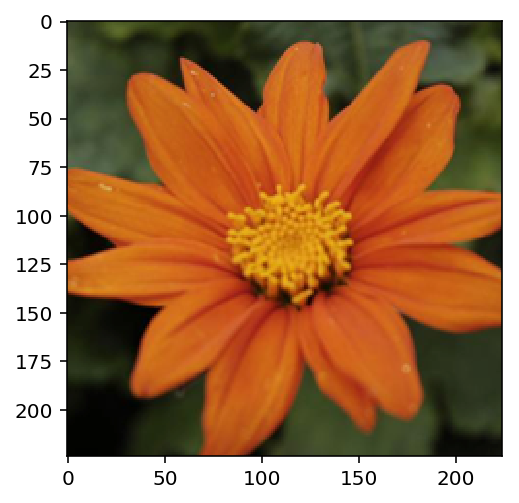

In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.array(image).transpose((1, 2, 0))
    #image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


imshow(process_image("flowers/test/59/image_05020.jpg"))

## Class Prediction

Once images are in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor, use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully have been added to the model or from an `ImageFolder`, we used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so we get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [14]:
def predict(image_path, model, topk=3):
    # load and process image
    img = process_image(image_path)
    # update to one sized dimension 
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    # converting to Tensor for correct pass to forward pass model 
    img = img.float()
    
    idx_to_class = {v:k for k, v in model.class_to_idx.items()}
    
    with torch.no_grad():
        ps = torch.exp(model.forward(img))
        top_prob, top_class = ps.topk(topk, dim=1)
    classes = [idx_to_class[x] for x in top_class.cpu().numpy()[0]]
    return top_prob[0], top_class, [cat_to_name[c] for c in classes]

## Sanity Checking

Now that we can use a trained ai model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

Convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

678 500
width > height
(57.5, 13.0, 281.5, 237.0)
678 500
width > height
(57.5, 13.0, 281.5, 237.0)
tensor([ 0.9936,  0.0062,  0.0001])
['blackberry lily', 'fritillary', 'anthurium']


<function matplotlib.pyplot.show(*args, **kw)>

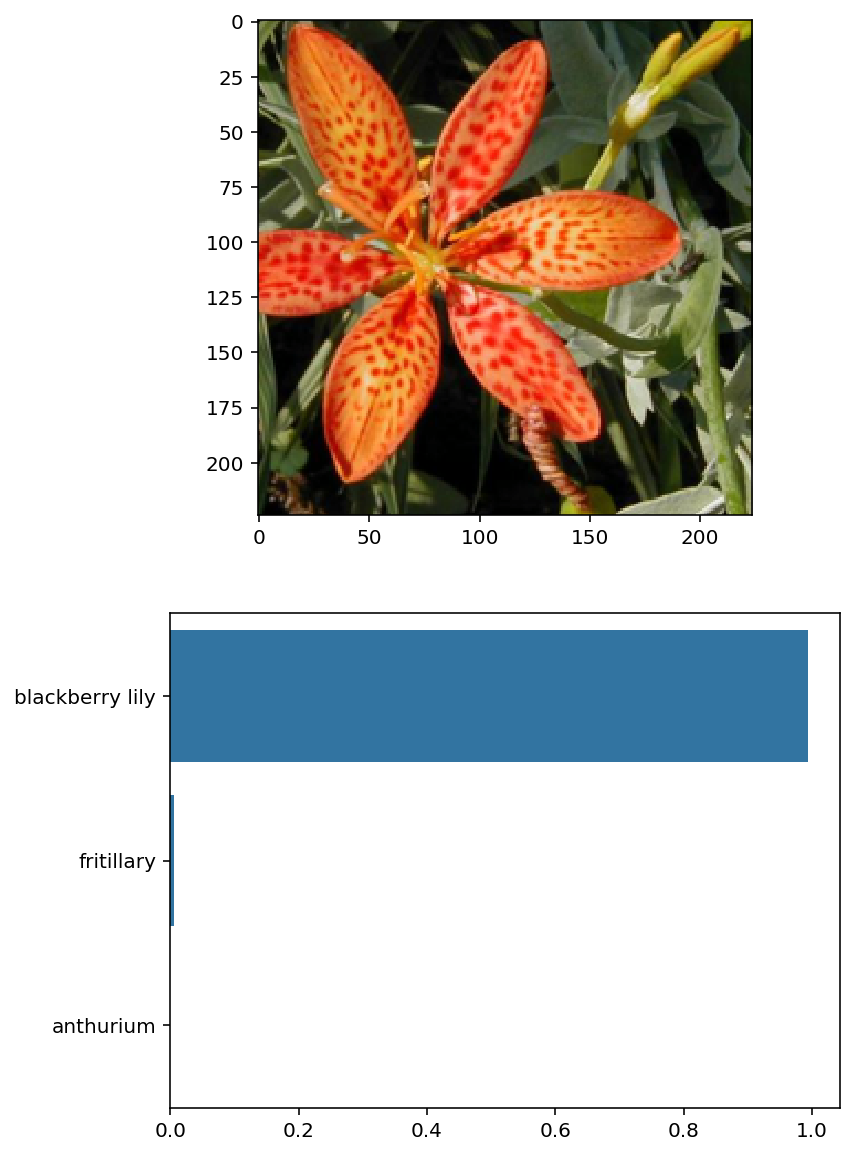

In [15]:
image_path = 'flowers/test/102/image_08042.jpg'

# Creating plot 
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# heading
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

# Plotting
img = process_image(image_path) 
imshow(img, ax, title = title_);

# ...predicting...
probs, labs, flowers = predict(image_path, model)
print(probs)
print(flowers)

# bar chart 
plt.subplot(2,1,2)
sns.barplot(x = probs, y = flowers, color = sns.color_palette()[0]);
plt.show

    

And just like that, we have a very accurate, fine tuned PyTorch Image Classifier! 